# Performance Predictor (PP) test drift

Test drift
- Change logs by percentage of similarity to an example. e.g. higher similarity of logs to less similarity.

In this notebook, we will display the results from the drift runs:
- 3 datasets: WebOfScience, Clinc150 and Jeopardy
- Different run prod sizes:
  - 50/50 split similar and dissimilar prod buckets
    - files named: half-large
  - top 25% and lowest 25% split similar and dissimilar prod sbuckets
    - large - 4609 train & 1000 test examples
      - files named: quartile-large
    - small - 2304 (4609/2) train and 500 test examples
      - files named: quartile-small
- display table accuracies and AUC ROC curves

#### Setup python environment

In [1]:
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from examples.blackbox_metamodel.util import NotebookUtils

os.environ["PYTHONWARNINGS"] = 'ignore'

pd.options.display.max_colwidth = 100

%load_ext autoreload
%autoreload 2

# Increase the width of the notebook so that it is the width of the browser 
# which allows larger size for the dashboard
display(HTML('<style>.container { width:100% !important; }</style>'))

2022-08-29 15:01:41.975552: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-29 15:01:41.975581: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


#### Load the results

In [2]:
%%time
data_dir = '../../data'
datasets_info = [
                 {'dataset':'webofscience', 'split':'half',     'size':'large', 'date':'2022-08-26'},
                 {'dataset':'webofscience', 'split':'quartile', 'size':'large', 'date':'2022-08-27'},
                 {'dataset':'webofscience', 'split':'quartile', 'size':'small', 'date':'2022-08-26'},
                 {'dataset':'clinc150',     'split':'half',     'size':'large', 'date':'2022-08-26'},
                 {'dataset':'clinc150',     'split':'quartile', 'size':'large', 'date':'2022-08-27'},
                 {'dataset':'clinc150',     'split':'quartile', 'size':'small', 'date':'2022-08-26'},
                 {'dataset':'jeopardy',     'split':'half',     'size':'large', 'date':'2022-08-26'},
                 {'dataset':'jeopardy',     'split':'quartile', 'size':'large', 'date':'2022-08-27'},
                 {'dataset':'jeopardy',     'split':'quartile', 'size':'small', 'date':'2022-08-26'},

                ]

for d in datasets_info:
    results_file = os.path.join(data_dir, f'{d["dataset"]}-drift-results-{d["split"]}-{d["size"]}-{d["date"]}.parquet')
    df = pd.read_parquet(results_file)
    experiments = df.to_dict(orient='records')
    d['experiments'] = experiments

CPU times: user 421 ms, sys: 61.9 ms, total: 483 ms
Wall time: 421 ms


#### Summarize results

,run,sim %,dis %,svc train accuracy,svc test accuracy,svc prod accuracy,pp prod accuracy,train size,test size,prod size,TH,TL,FH,FL,AUC
0,0,0.98,0.02,90.68%,54.39%,20.42%,32.22%,2307,513,11929,0.00%,20.42%,0.00%,79.58%,81.21%
1,1,0.96,0.04,91.24%,58.85%,23.20%,40.47%,2305,520,12119,0.00%,23.20%,0.00%,76.80%,70.76%
2,2,0.95,0.05,91.32%,56.31%,24.70%,41.83%,2305,515,12217,0.00%,24.70%,0.00%,75.30%,76.23%
3,3,0.94,0.06,91.63%,57.75%,27.56%,30.35%,2305,516,12317,0.15%,27.41%,0.03%,72.41%,70.02%
4,4,0.92,0.08,92.06%,57.28%,32.03%,41.83%,2305,515,12524,0.00%,32.03%,0.00%,67.97%,74.45%
5,5,0.90,0.10,92.45%,55.38%,36.41%,33.53%,2305,511,12740,1.54%,34.87%,0.10%,63.49%,69.57%
6,6,0.80,0.20,93.79%,57.34%,47.48%,50.42%,2304,504,13981,0.00%,47.48%,0.00%,52.52%,66.44%
7,7,0.70,0.30,93.66%,58.17%,52.65%,53.74%,2304,502,15579,0.00%,52.65%,0.00%,47.35%,69.35%
8,8,0.60,0.40,93.62%,52.89%,55.38%,53.29%,2304,501,17707,0.00%,55.38%,0.00%,44.62%,74.10%
9,9,0.50,0.50,94.23%,53.39%,57.13%,53.27%,2304,502,20684,0.43%,56.70%,0.01%,42.86%,64.51%


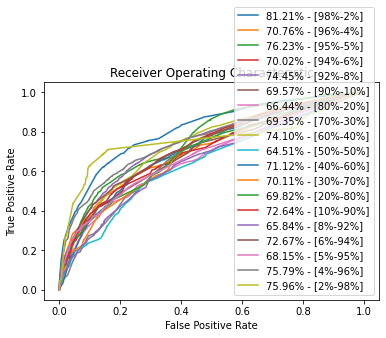

,run,sim %,dis %,svc train accuracy,svc test accuracy,svc prod accuracy,pp prod accuracy,train size,test size,prod size,TH,TL,FH,FL,AUC
0,0,0.98,0.02,98.22%,87.52%,62.34%,64.58%,2305,505,5682,9.10%,53.24%,0.19%,37.47%,81.25%
1,1,0.96,0.04,98.48%,88.39%,68.00%,77.54%,2304,508,5743,18.63%,49.36%,1.46%,30.54%,73.53%
2,2,0.95,0.05,98.61%,89.08%,71.98%,78.60%,2304,513,5774,35.05%,36.92%,2.13%,25.89%,80.36%
3,3,0.94,0.06,98.57%,90.91%,76.23%,80.79%,2304,506,5805,37.55%,38.67%,1.45%,22.33%,82.86%
4,4,0.92,0.08,98.57%,90.93%,78.90%,81.89%,2304,507,5871,38.78%,40.11%,2.11%,18.99%,79.08%
5,5,0.90,0.10,98.78%,89.88%,80.91%,84.86%,2304,504,5939,49.12%,31.79%,2.61%,16.48%,82.04%
6,6,0.80,0.20,99.00%,90.84%,87.06%,86.34%,2304,502,6330,35.20%,51.86%,1.36%,11.58%,74.43%
7,7,0.70,0.30,99.22%,91.40%,89.54%,89.21%,2304,500,6834,62.20%,27.33%,2.17%,8.30%,82.07%
8,8,0.60,0.40,99.18%,90.00%,90.53%,86.85%,2304,500,7505,66.45%,24.08%,1.17%,8.30%,85.39%
9,9,0.50,0.50,99.05%,91.40%,90.72%,91.19%,2304,500,8446,73.88%,16.84%,1.92%,7.36%,86.83%


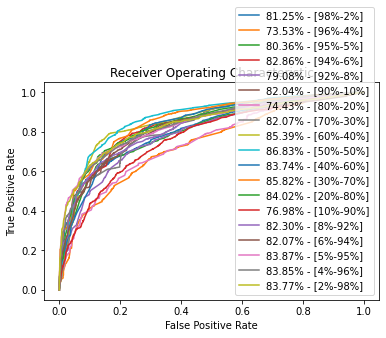

,run,sim %,dis %,svc train accuracy,svc test accuracy,svc prod accuracy,pp prod accuracy,train size,test size,prod size,TH,TL,FH,FL,AUC
0,0,0.98,0.02,91.54%,41.43%,33.23%,35.92%,2304,502,8264,0.00%,33.23%,0.00%,66.77%,66.21%
1,1,0.96,0.04,92.01%,42.83%,34.40%,41.65%,2304,509,8378,0.00%,34.40%,0.00%,65.60%,67.94%
2,2,0.95,0.05,92.10%,41.78%,34.86%,37.80%,2304,505,8437,0.02%,34.83%,0.00%,65.14%,72.36%
3,3,0.94,0.06,92.36%,40.16%,35.67%,34.87%,2304,503,8497,0.00%,35.67%,0.00%,64.33%,67.10%
4,4,0.92,0.08,92.14%,37.01%,36.75%,35.49%,2304,508,8621,0.00%,36.75%,0.01%,63.24%,69.12%
5,5,0.90,0.10,92.88%,45.74%,37.53%,43.98%,2304,505,8750,0.00%,37.53%,0.00%,62.47%,67.90%
6,6,0.80,0.20,92.71%,39.92%,40.41%,38.55%,2304,506,9492,0.00%,40.41%,0.00%,59.59%,67.42%
7,7,0.70,0.30,94.05%,40.36%,41.81%,40.35%,2304,503,10449,0.00%,41.81%,0.00%,58.19%,64.78%
8,8,0.60,0.40,94.75%,41.15%,42.66%,42.09%,2304,503,11722,0.00%,42.66%,0.00%,57.34%,62.80%
9,9,0.50,0.50,94.62%,45.51%,43.25%,44.80%,2304,501,13504,0.07%,43.17%,0.02%,56.73%,69.24%


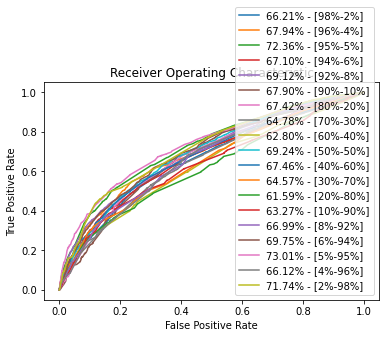

In [5]:
for d in datasets_info:
    if d['split'] == 'quartile' and d['size'] == 'small':
        display(HTML(f'<h2>{d["dataset"]} {d["split"]} {d["size"]} {d["date"]}</h2>'))
        plt.figure()
        data = []
        for e in d['experiments']:
            y_true = [1 if y==p else 0 for y,p in zip(e['y_prod'], e['svc_prod_pred'])]
            fpr, tpr, thresholds = roc_curve(y_true, e['pp_prod_score'], pos_label=1)
            auc = roc_auc_score(y_true, e['pp_prod_score'])
            plt.plot(fpr, tpr, label=f'{auc:.2%} - [{e["sim%"]:.0%}-{e["dis%"]:.0%}]')
            acc_train, _, _, _, _ = NotebookUtils().check_correctness(e['y_train'],  e['svc_train_pred'],  e['pp_train_score'])
            acc_test, _, _, _, _ = NotebookUtils().check_correctness(e['y_test'],  e['svc_test_pred'],  e['pp_test_score'])
            acc_split, _, _, _, _ = NotebookUtils().check_correctness(e['y_split'],  e['svc_split_pred'],  e['pp_split_score'])
            acc, th, tl, fh, fl = NotebookUtils().check_correctness(e['y_prod'],  e['svc_prod_pred'],  e['pp_prod_score'])
            data.append({'run': e['run'],
                         'sim %': e['sim%'],
                         'dis %': e['dis%'],
                         'svc train accuracy': acc_train,
                         'svc test accuracy': acc_test,
                         'svc prod accuracy': acc,
                         'pp prod accuracy': e['pp_prod_accuracy'],
                         'train size': len(e['y_train']),
                         'test size': len(e['y_test']),
                         'prod size': len(e['y_prod']),
                         'TH': th,
                         'TL': tl,
                         'FH': fh,
                         'FL': fl,
                         'AUC': auc,
            })

        pct_fmt = '{:,.2%}'.format
        fmt = {col: pct_fmt for col in ['svc train accuracy', 'pp train accuracy',
                                        'svc test accuracy', 'pp test accuracy',
                                        'svc split accuracy', 'pp split accuracy',
                                        'svc prod accuracy', 'pp prod accuracy', 'TH', 'TL', 'FH', 'FL', 'AUC']}
        display(HTML(pd.DataFrame(data).to_html(formatters=fmt)))

        plt.title('Receiver Operating Characteristic')
        plt.legend(loc='lower right')
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()

#### Detail results

In [3]:
# for d in datasets_info:
#     display(HTML(f'<h2>{d["dataset"]} {d["split"]} {d["size"]} {d["date"]}</h2>'))
#     plt.figure()
#     data = []
#     for e in d['experiments']:
#         y_true = [1 if y==p else 0 for y,p in zip(e['y_prod'], e['svc_prod_pred'])]
#         fpr, tpr, thresholds = roc_curve(y_true, e['pp_prod_score'], pos_label=1)
#         auc = roc_auc_score(y_true, e['pp_prod_score'])
#         plt.plot(fpr, tpr, label=f'{auc:.2%} - [{e["sim%"]:.0%}-{e["dis%"]:.0%}]')
#         acc_train, _, _, _, _ = NotebookUtils().check_correctness(e['y_train'],  e['svc_train_pred'],  e['pp_train_score'])
#         acc_test, _, _, _, _ = NotebookUtils().check_correctness(e['y_test'],  e['svc_test_pred'],  e['pp_test_score'])
#         acc_split, _, _, _, _ = NotebookUtils().check_correctness(e['y_split'],  e['svc_split_pred'],  e['pp_split_score'])
#         acc, th, tl, fh, fl = NotebookUtils().check_correctness(e['y_prod'],  e['svc_prod_pred'],  e['pp_prod_score'])
#         data.append({#'dataset': d['dataset'],
#                      #'split': d['split'],
#                      #'size': d['size'],
#                      #'date': d['date'],
#                      'run': e['run'],
#                      'sim %': e['sim%'],
#                      'dis %': e['dis%'],

#                      'train size': len(e['y_train']),
#                      'n uniq y_train': len(np.unique(e['y_train'])),
#                      'n y_train sim': e['n_y_train_sim'],
#                      'n y_train dis': e['n_y_train_dis'],
#                      'y_train sim %': e['n_y_train_sim'] / len(e['y_train']),
#                      'y_train dis %': e['n_y_train_dis'] / len(e['y_train']),
#                      'svc train accuracy': acc_train,
#                      'pp train accuracy': e['pp_train_accuracy'],

#                      'test size': len(e['y_test']),
#                      'n uniq y_test': len(np.unique(e['y_test'])),
#                      'n y_test sim': e['n_y_test_sim'],
#                      'n y_test dis': e['n_y_test_dis'],
#                      'y_test sim %': e['n_y_test_sim'] / len(e['y_test']),
#                      'y_test dis %': e['n_y_test_dis'] / len(e['y_test']),
#                      'svc test accuracy': acc_test,
#                      'pp test accuracy': e['pp_test_accuracy'],

#                      'svc split accuracy': acc_split,
#                      'pp split accuracy': e['pp_split_accuracy'],

#                      'prod size': len(e['y_prod']),
#                      'n uniq y_prod': len(np.unique(e['y_prod'])),
#                      'n y_prod sim': e['n_y_prod_sim'],
#                      'n y_prod dis': e['n_y_prod_dis'],
#                      'y_prod sim %': e['n_y_prod_sim'] / len(e['y_prod']),
#                      'y_prod dis %': e['n_y_prod_dis'] / len(e['y_prod']),
#                      'svc prod accuracy': acc,
#                      'pp prod accuracy': e['pp_prod_accuracy'],

#                      'TH': th,
#                      'TL': tl,
#                      'FH': fh,
#                      'FL': fl,
#                      'AUC': auc,
#         })

#     pct_fmt = '{:,.2%}'.format
#     fmt = {col: pct_fmt for col in ['svc train accuracy', 'pp train accuracy', 'svc test accuracy', 'pp test accuracy',
#                                     'svc split accuracy', 'pp split accuracy', 'svc prod accuracy', 'pp prod accuracy',
#                                     'TH', 'TL', 'FH', 'FL', 'AUC']}
#     for col in ['sim %', 'dis %', 'y_train sim %', 'y_train dis %',
#                 'y_test sim %', 'y_test dis %', 'y_prod sim %', 'y_prod dis %']:
#         fmt[col] = '{:,.0%}'.format

#     display(HTML(pd.DataFrame(data).to_html(formatters=fmt)))

#     plt.title('Receiver Operating Characteristic')
#     plt.legend(loc='lower right')
#     plt.ylabel('True Positive Rate')
#     plt.xlabel('False Positive Rate')
#     plt.show()